SAM-HQ
====

**Segment Anything in High Quality**
(aka HQ-SAM)

 * Paper: https://arxiv.org/abs/2306.01567

![SAM-HQ Model Architrcture](../assets/samhq_arch.jpg)

 * Installation

```bash
conda create -n samhq python=3.12 -y
pip install torch torchvision
pip install segment-anything-hq
pip install timm huggingface-hub matplotlib
```

 * Download model

```bash
from huggingface_hub import hf_hub_download

# Repository and filename
repo_id = "lkeab/hq-sam"
filename = "sam_hq_vit_b.pth"

# Download the file
model_path = hf_hub_download(
    repo_id=repo_id,
    filename=filename,
    local_dir="checkpoints",
    local_dir_use_symlinks=False
)

print(f"Model downloaded to: {model_path}")
```

In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch
from segment_anything_hq import (
    sam_model_registry,
    SamPredictor
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_type = "vit_b"
checkpoint_path = "checkpoints/sam_hq_vit_b.pth"

sam = sam_model_registry[model_type](checkpoint=checkpoint_path)
sam.to(device=device)

predictor = SamPredictor(sam)
predictor.model.eval();

/home/pyml/anaconda3/envs/samhq/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/pyml/anaconda3/envs/samhq/lib/python3.12/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/home/pyml/anaconda3/envs/samhq/lib/python3.12/site-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
/home/pyml/anaconda3/envs/samhq/lib/python3.12/site-packages/segment_anything_hq/modeling/tiny_vit_sam.py:662: UserWarning: Overwriting tiny_vit_5m_

<All keys matched successfully>


In [2]:
image_path = "../samples/plants.jpg"
image = Image.open(image_path).convert("RGB")
image_np = np.array(image)
predictor.set_image(image_np)

### Point-based inference

(1, 1137, 1068) float32
-46.651592 25.138884
5.4887178e-21 1.0


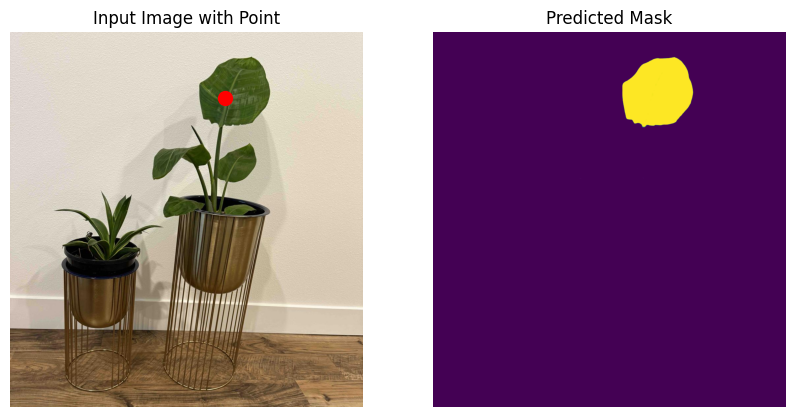

In [3]:
input_points = np.array([(650, 200)])

logits, _, _ = predictor.predict(
    point_coords=input_points,
    point_labels=np.array([1]),
    box=None,
    multimask_output=True,
    return_logits=True
)

print(logits.shape, logits.dtype)
probas = torch.sigmoid(torch.from_numpy(logits))[0].numpy()
print(logits.min(), logits.max())
print(probas.min(), probas.max())

fig, axes = plt.subplots(1, 2, figsize=(10, 5), dpi=100)
axes[0].imshow(image_np)
axes[0].scatter(
    input_points[:, 0], input_points[:, 1],
    color="red", s=100
)
axes[0].set_title("Input Image with Point")
axes[0].axis("off")
axes[1].imshow(probas)
axes[1].set_title("Predicted Mask")
axes[1].axis("off")
plt.show()

## Box-based inference

(1, 1137, 1068) float32
-27.846523 18.88249
8.061365e-13 1.0


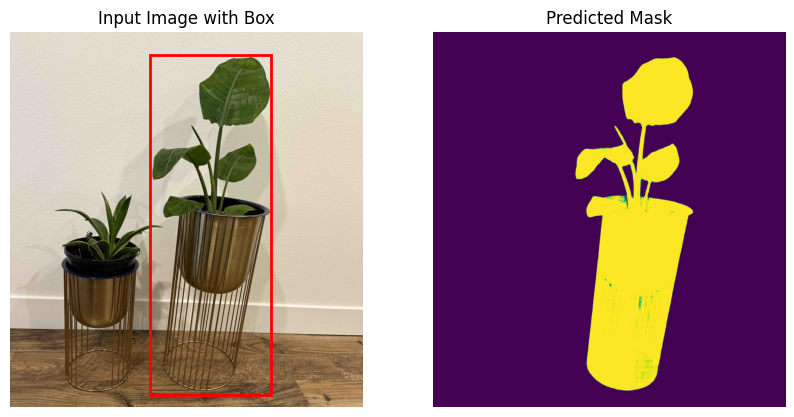

In [4]:
box = np.array([[425, 70, 790, 1100]])
logits, _, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=box,
    multimask_output=True,
    return_logits=True
)
print(logits.shape, logits.dtype)
probas = torch.sigmoid(torch.from_numpy(logits))[0].numpy()
print(logits.min(), logits.max())
print(probas.min(), probas.max())
fig, axes = plt.subplots(1, 2, figsize=(10, 5), dpi=100)
axes[0].imshow(image_np)
axes[0].add_patch(plt.Rectangle(
    (box[0, 0], box[0, 1]),
    box[0, 2] - box[0, 0],
    box[0, 3] - box[0, 1],
    edgecolor="red", facecolor="none", lw=2
))
axes[0].set_title("Input Image with Box")
axes[0].axis("off")
axes[1].imshow(probas)
axes[1].set_title("Predicted Mask")
axes[1].axis("off")
plt.show()